#  Shor's Algorithm: The Quantum Threat to RSA

## A Rigorous Educational Simulation

---

### [!] CRITICAL DISCLAIMERS

> ** EDUCATIONAL SIMULATION ONLY**
>
> This notebook demonstrates Shor's algorithm using **toy examples** (factoring N=15).
> 
> **What this IS:**
> - A pedagogical tool to understand quantum period finding
> - A classical simulation of quantum circuits using Qiskit
> - A demonstration of the *algorithm*, not a practical attack
>
> **What this is NOT:**
> - A threat to any real cryptographic system
> - An actual quantum computation (we're simulating on a classical computer)
> - Scalable to cryptographically relevant key sizes

> ** MEMORY WARNING**
>
> **DO NOT** attempt to factor numbers larger than ~35 on a standard laptop!
> 
> Quantum state vectors grow as $2^n$ where $n$ = number of qubits.
> - N=15 requires ~8 qubits → $2^8$ = 256 amplitudes [OK]
> - N=21 requires ~10 qubits → $2^{10}$ = 1,024 amplitudes [OK]
> - N=2048-bit RSA would require ~4000+ qubits → $2^{4000}$ amplitudes 💥
> 
> This exponential explosion is precisely why quantum computers are hard to simulate classically!

---

###  Learning Objectives

After completing this notebook, you will understand:

1. The **reduction** of integer factorization to period finding
2. The structure of Shor's algorithm: **quantum period finding** + **classical post-processing**
3. How to construct quantum circuits for modular exponentiation
4. The role of the **Quantum Fourier Transform (QFT)** in extracting periodicity
5. Why this algorithm threatens RSA (in principle, not yet in practice)

---

## Part 1: Theoretical Foundations

### 1.1 The Core Insight: Factoring via Period Finding

Shor's brilliant insight was that **integer factorization** can be reduced to **period finding** — a problem that quantum computers solve exponentially faster than classical ones.

#### The Setup

Given $N = p \times q$ (product of two primes), we want to find $p$ and $q$.

**Key observation:** For a random $a$ coprime to $N$, consider the function:

$$f(x) = a^x \mod N$$

This function is **periodic** with some period $r$:

$$a^r \equiv 1 \pmod{N} \quad \text{and} \quad f(x+r) = f(x) \text{ for all } x$$

#### From Period to Factors

Once we find the period $r$:

1. If $r$ is **even**, then we can write:
   $$a^r - 1 \equiv 0 \pmod{N}$$
   $$(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \pmod{N}$$

2. If $a^{r/2} \not\equiv \pm 1 \pmod{N}$, then:
   $$\gcd(a^{r/2} - 1, N) \quad \text{or} \quad \gcd(a^{r/2} + 1, N)$$
   gives a **non-trivial factor** of $N$!

#### The Quantum Advantage

| Task | Classical Complexity | Quantum Complexity |
|------|---------------------|--------------------|
| Period Finding | $O(2^{n/2})$ — exponential | $O(n^2 \log n)$ — polynomial |
| GCD Calculation | $O(n)$ — already efficient | (same, done classically) |

The quantum speedup is **entirely in the period finding step**.

### 1.2 Shor's Algorithm: High-Level Structure

```
┌─────────────────────────────────────────────────────────────────────────┐
│                        SHOR'S ALGORITHM                                  │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  ┌──────────────────────────────────────────────────────────────────┐   │
│  │                    CLASSICAL PRE-PROCESSING                       │   │
│  │  1. Check if N is even → factor = 2                               │   │
│  │  2. Check if N = a^b for some integers → factor = a               │   │
│  │  3. Pick random a where 1 < a < N                                 │   │
│  │  4. Compute gcd(a, N) → if > 1, we're done!                       │   │
│  └──────────────────────────────────────────────────────────────────┘   │
│                               ↓                                          │
│  ┌──────────────────────────────────────────────────────────────────┐   │
│  │               QUANTUM PERIOD FINDING                          │   │
│  │  Input: a, N                                                      │   │
│  │  Output: Estimate of period r where a^r ≡ 1 (mod N)               │   │
│  │                                                                    │   │
│  │  |0⟩───[H]───[Oracle: a^x mod N]───[QFT†]───[Measure]            │   │
│  └──────────────────────────────────────────────────────────────────┘   │
│                               ↓                                          │
│  ┌──────────────────────────────────────────────────────────────────┐   │
│  │                   CLASSICAL POST-PROCESSING                       │   │
│  │  1. Use continued fractions to extract r from measurement         │   │
│  │  2. Check if r is even                                            │   │
│  │  3. Compute gcd(a^(r/2) ± 1, N) to get factors                    │   │
│  │  4. If failed, repeat with different a                            │   │
│  └──────────────────────────────────────────────────────────────────┘   │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

**Critical distinction:**
- 🔵 **Quantum part**: Only the period finding (middle box)
- 🟢 **Classical part**: Everything else (pre-processing, GCD, factor extraction)

### 1.3 The Quantum Circuit: Mathematical Description

The quantum period finding circuit operates as follows:

#### Step 1: Initialization

We use two quantum registers:
- **Counting register**: $n$ qubits initialized to $|0\rangle^{\otimes n}$
- **Target register**: $m$ qubits initialized to $|1\rangle$ (to hold $a^x \mod N$)

#### Step 2: Create Superposition

Apply Hadamard gates to the counting register:

$$H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle$$

#### Step 3: Apply Modular Exponentiation Oracle

Apply the unitary $U_a$ that computes $a^x \mod N$:

$$|x\rangle|1\rangle \xrightarrow{U_a} |x\rangle|a^x \mod N\rangle$$

After this step:
$$\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle|a^x \mod N\rangle$$

#### Step 4: Apply Inverse QFT

The Quantum Fourier Transform is defined as:

$$\text{QFT}|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1} e^{2\pi i xy / 2^n} |y\rangle$$

Applying $\text{QFT}^\dagger$ (inverse QFT) to the counting register creates **constructive interference** at values $y$ that are multiples of $2^n/r$.

#### Step 5: Measurement

Measuring the counting register gives us a value $y$ such that:

$$\frac{y}{2^n} \approx \frac{k}{r}$$

for some integer $k$. Using continued fractions, we can extract $r$.

---

## Part 2: Setting Up the Environment

Let's import the necessary libraries and verify our setup.

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from math import gcd, log2, ceil
from fractions import Fraction
from typing import Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Qiskit imports
try:
    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
    from qiskit.visualization import plot_histogram
    from qiskit_aer import AerSimulator
    QISKIT_AVAILABLE = True
    print("[OK] Qiskit imported successfully!")
    
    # Check version
    import qiskit
    print(f"   Qiskit version: {qiskit.__version__}")
    
except ImportError as e:
    QISKIT_AVAILABLE = False
    print("[X] Qiskit not available. Install with:")
    print("   pip install qiskit qiskit-aer")
    print(f"   Error: {e}")

print("\n[OK] Environment setup complete!")

[OK] Qiskit imported successfully!
   Qiskit version: 2.1.2

[OK] Environment setup complete!


---

## Part 3: Understanding the Periodicity (Classical Demonstration)

Before building quantum circuits, let's visualize the periodic function $f(x) = a^x \mod N$.

For our toy example: **N = 15**, **a = 7**

In [2]:
# =============================================================================
# VISUALIZING THE PERIODIC FUNCTION f(x) = a^x mod N
# =============================================================================

#  INTERACTIVE: You can try different values of 'a'
# Valid choices for N=15: a ∈ {2, 4, 7, 8, 11, 13, 14} (coprime to 15)
N = 15
a = 7  # Try: 2, 4, 7, 8, 11, 13, 14

print("="*60)
print(f"PERIODIC FUNCTION: f(x) = {a}^x mod {N}")
print("="*60)

# Compute function values
x_values = list(range(20))
f_values = [pow(a, x, N) for x in x_values]

# Display table
print(f"\n{'x':<4} | {'a^x mod N':<10} | Pattern")
print("-" * 35)

period = None
for x, fx in zip(x_values, f_values):
    marker = "← Period starts" if fx == 1 and x > 0 and period is None else ""
    if fx == 1 and x > 0 and period is None:
        period = x
    print(f"{x:<4} | {fx:<10} | {marker}")

print(f"\n Period r = {period}")
print(f"   Verification: {a}^{period} mod {N} = {pow(a, period, N)} [OK]")

PERIODIC FUNCTION: f(x) = 7^x mod 15

x    | a^x mod N  | Pattern
-----------------------------------
0    | 1          | 
1    | 7          | 
2    | 4          | 
3    | 13         | 
4    | 1          | ← Period starts
5    | 7          | 
6    | 4          | 
7    | 13         | 
8    | 1          | 
9    | 7          | 
10   | 4          | 
11   | 13         | 
12   | 1          | 
13   | 7          | 
14   | 4          | 
15   | 13         | 
16   | 1          | 
17   | 7          | 
18   | 4          | 
19   | 13         | 

 Period r = 4
   Verification: 7^4 mod 15 = 1 [OK]


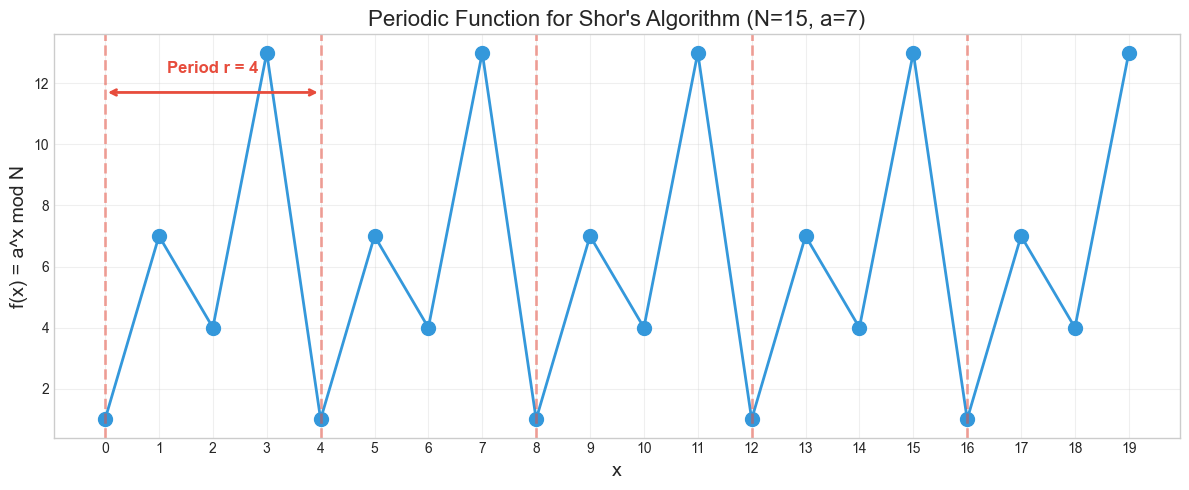


📌 The quantum circuit will find this period r using interference!


In [3]:
# Visualize the periodic function
fig, ax = plt.subplots(figsize=(12, 5))

# Plot
ax.plot(x_values, f_values, 'o-', linewidth=2, markersize=10, color='#3498db')

# Mark period
for i in range(0, 20, period):
    ax.axvline(x=i, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)

# Add period annotation
ax.annotate('', xy=(period, max(f_values) * 0.9), xytext=(0, max(f_values) * 0.9),
            arrowprops=dict(arrowstyle='<->', color='#e74c3c', lw=2))
ax.text(period/2, max(f_values) * 0.95, f'Period r = {period}', 
        ha='center', fontsize=12, color='#e74c3c', fontweight='bold')

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel(f'f(x) = a^x mod N', fontsize=14)
ax.set_title(f'Periodic Function for Shor\'s Algorithm (N={N}, a={a})', fontsize=16)
ax.set_xticks(x_values)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 The quantum circuit will find this period r using interference!")

---

## Part 4: Building the Quantum Circuit

### 4.1 The Controlled Modular Multiplication Oracle

For N=15 and a=7, we need to implement the unitary:

$$U|y\rangle = |7y \mod 15\rangle$$

And its controlled powers: $U^{2^k}|y\rangle = |7^{2^k} y \mod 15\rangle$

**Important Note:** This oracle is **hardcoded** for N=15. A general modular exponentiation circuit is extremely complex (the main overhead in Shor's algorithm). For educational clarity, we use precomputed permutations.

In [4]:
def c_amod15(a: int, power: int) -> QuantumCircuit:
    """
    Controlled multiplication by a^power mod 15.
    
    This is a HARDCODED oracle for N=15 only.
    
    In a real implementation, this would be the most complex part,
    requiring O(n^2) or O(n^3) gates for general modular exponentiation.
    
    For N=15, we can use optimized swap-based circuits.
    
    Args:
        a: Base (must be coprime to 15)
        power: Exponent (we compute a^power mod 15)
    
    Returns:
        QuantumCircuit implementing controlled-U^power
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError(f"a={a} must be coprime to 15 and in {{2,4,7,8,11,13}}")
    
    # 4 qubits to represent numbers 0-15
    U = QuantumCircuit(4, name=f"{a}^{power} mod 15")
    
    # Compute effective exponent
    effective_a = pow(a, power, 15)
    
    # Hardcoded permutations for each multiplier
    # These implement |y⟩ → |a*y mod 15⟩ using swap gates
    
    if effective_a == 1:
        pass  # Identity
    elif effective_a == 2:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    elif effective_a == 4:
        U.swap(0, 2)
        U.swap(1, 3)
    elif effective_a == 7:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
        U.x(0)
        U.x(1)
        U.x(2)
        U.x(3)
    elif effective_a == 8:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    elif effective_a == 11:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
        U.x(0)
        U.x(1)
        U.x(2)
        U.x(3)
    elif effective_a == 13:
        U.swap(0, 2)
        U.swap(1, 3)
        U.x(0)
        U.x(1)
        U.x(2)
        U.x(3)
    
    # Convert to controlled gate
    gate = U.to_gate()
    c_gate = gate.control(1)
    
    return c_gate


# Demonstrate the oracle
print("="*60)
print("MODULAR MULTIPLICATION ORACLE")
print("="*60)
print("\nThis oracle computes: |y⟩ → |a×y mod 15⟩")
print("\nFor a=7:")
print(f"  7^1 mod 15 = {pow(7, 1, 15)}")
print(f"  7^2 mod 15 = {pow(7, 2, 15)}")
print(f"  7^4 mod 15 = {pow(7, 4, 15)}")
print(f"  7^8 mod 15 = {pow(7, 8, 15)}")

print("\n[!] Note: This oracle is HARDCODED for N=15.")
print("   General modular exponentiation is the main complexity of Shor's algorithm.")

MODULAR MULTIPLICATION ORACLE

This oracle computes: |y⟩ → |a×y mod 15⟩

For a=7:
  7^1 mod 15 = 7
  7^2 mod 15 = 4
  7^4 mod 15 = 1
  7^8 mod 15 = 1

[!] Note: This oracle is HARDCODED for N=15.
   General modular exponentiation is the main complexity of Shor's algorithm.


### 4.2 Inverse Quantum Fourier Transform (QFT†)

The inverse QFT extracts periodicity from the quantum state.

$$\text{QFT}^\dagger|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1} e^{-2\pi i xy / 2^n} |y\rangle$$

In [5]:
def qft_dagger(n: int) -> QuantumCircuit:
    """
    Create an n-qubit inverse Quantum Fourier Transform circuit.
    
    The QFT† converts amplitude information about periodicity
    into measurement probabilities that reveal the period.
    
    Args:
        n: Number of qubits
    
    Returns:
        QuantumCircuit implementing QFT†
    """
    qc = QuantumCircuit(n, name="QFT†")
    
    # Apply operations in reverse order of QFT
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    
    for j in range(n):
        for m in range(j):
            angle = -np.pi / float(2 ** (j - m))
            qc.cp(angle, m, j)
        qc.h(j)
    
    return qc


# Show the QFT† circuit for 4 qubits
print("="*60)
print("INVERSE QUANTUM FOURIER TRANSFORM (QFT†)")
print("="*60)

qft_circuit = qft_dagger(4)
print("\nQFT† circuit for 4 qubits:")
print(qft_circuit.draw(output='text'))

INVERSE QUANTUM FOURIER TRANSFORM (QFT†)

QFT† circuit for 4 qubits:
        ┌───┐                                                            »
q_0: ─X─┤ H ├─■──────────────■───────────────────■───────────────────────»
      │ └───┘ │P(-π/2) ┌───┐ │                   │                       »
q_1: ─┼───X───■────────┤ H ├─┼─────────■─────────┼──────────────■────────»
      │   │            └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │        »
q_2: ─┼───X──────────────────■─────────■─────────┼────────┤ H ├─┼────────»
      │                                          │P(-π/8) └───┘ │P(-π/4) »
q_3: ─X──────────────────────────────────────────■──────────────■────────»
                                                                         »
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«                    
«q_2: ─■─────────────
«      │P(-π/2) ┌───┐
«q_3: ─■────────┤ H ├
«               └───┘


### 4.3 Complete Shor's Circuit Construction

Now we assemble the complete quantum circuit for period finding.

In [6]:
def build_shors_circuit(N: int, a: int, n_count: int = 8) -> QuantumCircuit:
    """
    Build the complete quantum circuit for Shor's algorithm.
    
    Circuit structure:
    1. Counting register (n_count qubits) - initialized with H gates
    2. Target register (4 qubits for N=15) - initialized to |1⟩
    3. Controlled modular exponentiation
    4. Inverse QFT on counting register
    5. Measurement
    
    Args:
        N: Number to factor (only N=15 supported in this demo)
        a: Base for modular exponentiation (must be coprime to N)
        n_count: Number of counting qubits (more = better precision)
    
    Returns:
        QuantumCircuit ready for simulation
    """
    if N != 15:
        raise ValueError("This demo only supports N=15")
    
    n_target = 4  # Qubits needed to represent 0-15
    
    # Create quantum circuit
    qc = QuantumCircuit(n_count + n_target, n_count)
    
    print("="*60)
    print(f"BUILDING SHOR'S CIRCUIT for N={N}, a={a}")
    print("="*60)
    
    # STEP 1: Initialize counting register with Hadamard gates
    print(f"\n[Step 1] Apply Hadamard to counting register ({n_count} qubits)")
    print(f"         Creates superposition: |0⟩ → 1/√2^n Σ|x⟩")
    for q in range(n_count):
        qc.h(q)
    
    # STEP 2: Initialize target register to |1⟩
    print(f"\n[Step 2] Initialize target register to |1⟩")
    print(f"         (Since a^0 mod N = 1)")
    qc.x(n_count)  # Set target to |0001⟩ = |1⟩
    
    qc.barrier()
    
    # STEP 3: Apply controlled modular exponentiation
    print(f"\n[Step 3] Apply controlled-U^(2^k) operations")
    print(f"         Each counting qubit controls U^(2^k) = |y⟩ → |a^(2^k)·y mod N⟩")
    for q in range(n_count):
        power = 2 ** q
        c_gate = c_amod15(a, power)
        qc.append(c_gate, [q] + list(range(n_count, n_count + n_target)))
    
    qc.barrier()
    
    # STEP 4: Apply inverse QFT to counting register
    print(f"\n[Step 4] Apply inverse QFT to counting register")
    print(f"         Converts periodicity to measurable phases")
    qft_dag = qft_dagger(n_count)
    qc.append(qft_dag, range(n_count))
    
    qc.barrier()
    
    # STEP 5: Measure counting register
    print(f"\n[Step 5] Measure counting register")
    print(f"         Result encodes information about period r")
    qc.measure(range(n_count), range(n_count))
    
    print(f"\n[OK] Circuit complete!")
    print(f"   Total qubits: {n_count + n_target}")
    print(f"   Counting qubits: {n_count}")
    print(f"   Target qubits: {n_target}")
    
    return qc


# Build the circuit
#  INTERACTIVE: Try different values of n_count (4, 6, 8)
# More qubits = better precision for period estimation
N = 15
a = 7
n_count_qubits = 8  # Try: 4, 6, 8

shor_circuit = build_shors_circuit(N, a, n_count_qubits)

BUILDING SHOR'S CIRCUIT for N=15, a=7

[Step 1] Apply Hadamard to counting register (8 qubits)
         Creates superposition: |0⟩ → 1/√2^n Σ|x⟩

[Step 2] Initialize target register to |1⟩
         (Since a^0 mod N = 1)

[Step 3] Apply controlled-U^(2^k) operations
         Each counting qubit controls U^(2^k) = |y⟩ → |a^(2^k)·y mod N⟩

[Step 4] Apply inverse QFT to counting register
         Converts periodicity to measurable phases

[Step 5] Measure counting register
         Result encodes information about period r

[OK] Circuit complete!
   Total qubits: 12
   Counting qubits: 8
   Target qubits: 4


In [7]:
# Display the circuit
print("\n" + "="*60)
print("QUANTUM CIRCUIT DIAGRAM")
print("="*60)
print("\nNote: q0-q7 = counting register, q8-q11 = target register")
print("\n")

# Draw circuit (decomposed for clarity)
print(shor_circuit.draw(output='text', fold=120))


QUANTUM CIRCUIT DIAGRAM

Note: q0-q7 = counting register, q8-q11 = target register


      ┌───┐ ░                                                                                             »
 q_0: ┤ H ├─░────────■────────────────────────────────────────────────────────────────────────────────────»
      ├───┤ ░        │                                                                                    »
 q_1: ┤ H ├─░────────┼──────────────■─────────────────────────────────────────────────────────────────────»
      ├───┤ ░        │              │                                                                     »
 q_2: ┤ H ├─░────────┼──────────────┼──────────────■──────────────────────────────────────────────────────»
      ├───┤ ░        │              │              │                                                      »
 q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■───────────────────────────────────────»
      ├───┤ ░        │              │             

---

## Part 5: Simulation and Measurement

### 5.1 Running the Quantum Simulation

We use Qiskit's `AerSimulator` to classically simulate the quantum circuit.

**Remember:** This is a *classical simulation* of quantum mechanics. A real quantum computer would run this natively.

In [8]:
# =============================================================================
# QUANTUM SIMULATION
# =============================================================================

print("="*60)
print("RUNNING QUANTUM SIMULATION")
print("="*60)

# Create simulator
simulator = AerSimulator()

# Transpile for simulator
transpiled_circuit = transpile(shor_circuit, simulator)

# Run simulation
#  INTERACTIVE: Try different shot counts
SHOTS = 1024  # Number of measurements

print(f"\nRunning {SHOTS} shots...")
job = simulator.run(transpiled_circuit, shots=SHOTS)
result = job.result()
counts = result.get_counts()

print(f"\n[OK] Simulation complete!")
print(f"   Unique measurement outcomes: {len(counts)}")

# Display top results
print(f"\n Top measurement results:")
print(f"{'Binary':<12} {'Decimal':<10} {'Counts':<10} {'Probability':<12}")
print("-" * 45)

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for bitstring, count in sorted_counts[:10]:
    decimal = int(bitstring, 2)
    prob = count / SHOTS
    print(f"{bitstring:<12} {decimal:<10} {count:<10} {prob:.4f}")

RUNNING QUANTUM SIMULATION



Running 1024 shots...

[OK] Simulation complete!
   Unique measurement outcomes: 4

 Top measurement results:
Binary       Decimal    Counts     Probability 
---------------------------------------------
10000000     128        261        0.2549
01000000     64         260        0.2539
11000000     192        258        0.2520
00000000     0          245        0.2393


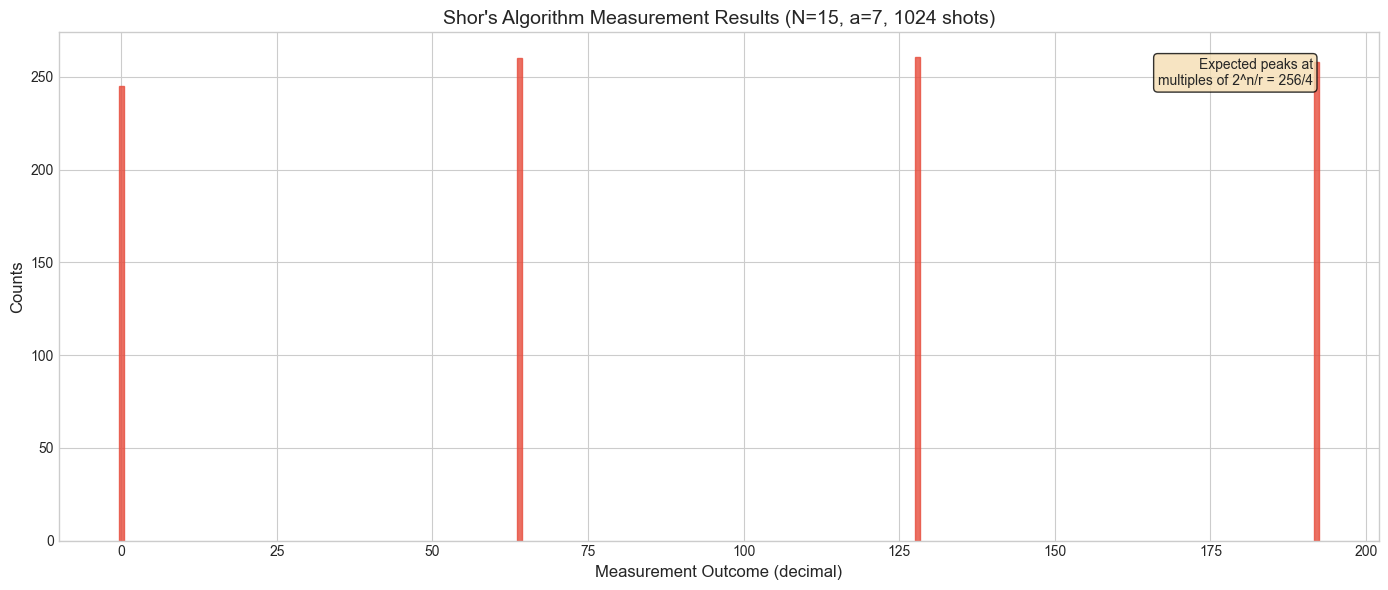


📌 Peaks (red bars) correspond to multiples of 2^n/r
   From these peaks, we can deduce the period r!


In [9]:
# Visualize the histogram
fig, ax = plt.subplots(figsize=(14, 6))

# Convert to integers for plotting
int_counts = {int(k, 2): v for k, v in counts.items()}

# Plot
x_vals = sorted(int_counts.keys())
y_vals = [int_counts[x] for x in x_vals]

bars = ax.bar(x_vals, y_vals, color='#3498db', edgecolor='white', alpha=0.8)

# Highlight peaks (expected at multiples of 2^n / r)
# For N=15, a=7, r=4, we expect peaks at 0, 64, 128, 192 (for n=8)
expected_peaks = [0, 64, 128, 192]  # 256/4 = 64
for peak in expected_peaks:
    if peak in int_counts:
        idx = x_vals.index(peak)
        bars[idx].set_color('#e74c3c')

ax.set_xlabel('Measurement Outcome (decimal)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title(f'Shor\'s Algorithm Measurement Results (N={N}, a={a}, {SHOTS} shots)', fontsize=14)

# Add annotation for expected peaks
ax.text(0.95, 0.95, f'Expected peaks at\nmultiples of 2^n/r = {2**n_count_qubits}/{period}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n📌 Peaks (red bars) correspond to multiples of 2^n/r")
print("   From these peaks, we can deduce the period r!")

---

## Part 6: Classical Post-Processing

### 6.1 Extracting the Period Using Continued Fractions

The measurement gives us a value $y$ such that:

$$\frac{y}{2^n} \approx \frac{k}{r}$$

where $r$ is the period we seek. Using **continued fraction expansion**, we can find $r$.

**This post-processing is entirely classical!**

In [10]:
def find_period_from_measurement(measured: int, n_count: int, N: int, a: int) -> List[int]:
    """
    Use continued fractions to extract possible periods from a measurement.
    
    This is the CLASSICAL POST-PROCESSING step of Shor's algorithm.
    
    Args:
        measured: The measured integer value from the quantum circuit
        n_count: Number of counting qubits
        N: Number being factored
        a: Base used in modular exponentiation
    
    Returns:
        List of candidate periods
    """
    if measured == 0:
        return []  # Zero gives no information
    
    # Phase estimate
    phase = measured / (2 ** n_count)
    
    # Use continued fraction expansion
    # Limit denominator to N (period can't be larger than N)
    frac = Fraction(phase).limit_denominator(N)
    
    r_candidate = frac.denominator
    
    # Verify: check if a^r ≡ 1 (mod N)
    candidates = []
    
    # Check r and multiples of r
    for mult in [1, 2, 3, 4]:
        test_r = r_candidate * mult
        if test_r <= N and pow(a, test_r, N) == 1:
            candidates.append(test_r)
    
    return candidates


def extract_factors(N: int, a: int, r: int) -> Tuple[Optional[int], Optional[int]]:
    """
    Extract factors of N given the period r.
    
    Uses the identity: (a^(r/2) - 1)(a^(r/2) + 1) ≡ 0 (mod N)
    
    Args:
        N: Number to factor
        a: Base used
        r: Period found
    
    Returns:
        (p, q) if successful, (None, None) otherwise
    """
    if r % 2 != 0:
        return None, None  # r must be even
    
    x = pow(a, r // 2, N)
    
    if x == N - 1:  # x ≡ -1 (mod N)
        return None, None  # Trivial case
    
    # Compute factors
    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)
    
    # Check for non-trivial factors
    if factor1 not in [1, N]:
        return factor1, N // factor1
    if factor2 not in [1, N]:
        return factor2, N // factor2
    
    return None, None


# =============================================================================
# CLASSICAL POST-PROCESSING
# =============================================================================

print("="*60)
print("CLASSICAL POST-PROCESSING")
print("="*60)
print("\n[!] This entire step runs on a CLASSICAL computer!")
print("   The quantum computer only provided the measurements.\n")

print(f"Target: Factor N = {N}")
print(f"Using: a = {a}")
print(f"Counting qubits: {n_count_qubits}")
print(f"\n" + "-"*60)

# Analyze each measurement
successful_attempts = []

print(f"\n{'Measured':<10} {'Phase':<12} {'Fraction':<12} {'Period r':<10} {'Factors':<15}")
print("-" * 65)

for bitstring, count in sorted_counts[:15]:
    measured = int(bitstring, 2)
    
    if measured == 0:
        print(f"{measured:<10} {'(skip)':<12}")
        continue
    
    phase = measured / (2 ** n_count_qubits)
    frac = Fraction(phase).limit_denominator(N)
    
    # Find candidate periods
    candidates = find_period_from_measurement(measured, n_count_qubits, N, a)
    
    if candidates:
        for r in candidates:
            p, q = extract_factors(N, a, r)
            
            factor_str = f"{p} × {q}" if p else "(trivial)"
            print(f"{measured:<10} {phase:<12.4f} {str(frac):<12} {r:<10} {factor_str:<15}")
            
            if p and q:
                successful_attempts.append((measured, r, p, q))
    else:
        print(f"{measured:<10} {phase:<12.4f} {str(frac):<12} {'(none)':<10}")

CLASSICAL POST-PROCESSING

[!] This entire step runs on a CLASSICAL computer!
   The quantum computer only provided the measurements.

Target: Factor N = 15
Using: a = 7
Counting qubits: 8

------------------------------------------------------------

Measured   Phase        Fraction     Period r   Factors        
-----------------------------------------------------------------
128        0.5000       1/2          4          3 × 5          
128        0.5000       1/2          8          (trivial)      
64         0.2500       1/4          4          3 × 5          
64         0.2500       1/4          8          (trivial)      
64         0.2500       1/4          12         3 × 5          
192        0.7500       3/4          4          3 × 5          
192        0.7500       3/4          8          (trivial)      
192        0.7500       3/4          12         3 × 5          
0          (skip)      


In [11]:
# Final results
print("\n" + "="*60)
print(" FINAL FACTORIZATION RESULTS")
print("="*60)

if successful_attempts:
    # Use the most common successful result
    measured, r, p, q = successful_attempts[0]
    
    print(f"\n[OK] SUCCESS! N = {N} = {p} × {q}")
    print(f"\n   Method:")
    print(f"   1. Quantum circuit measured: {measured}")
    print(f"   2. Phase estimate: {measured}/{2**n_count_qubits} = {measured/(2**n_count_qubits):.4f}")
    print(f"   3. Continued fraction gave period: r = {r}")
    print(f"   4. Computed a^(r/2) = {a}^{r//2} mod {N} = {pow(a, r//2, N)}")
    print(f"   5. gcd({pow(a, r//2, N)} - 1, {N}) = {gcd(pow(a, r//2, N) - 1, N)}")
    print(f"   6. gcd({pow(a, r//2, N)} + 1, {N}) = {gcd(pow(a, r//2, N) + 1, N)}")
    print(f"\n   [OK] Factors verified: {p} × {q} = {p * q}")
else:
    print("\n[X] No successful factorization in this run.")
    print("   This is expected sometimes due to the probabilistic nature of the algorithm.")
    print("   Solutions:")
    print("   1. Run again (different random outcomes)")
    print("   2. Increase the number of counting qubits")
    print("   3. Increase the number of shots")


 FINAL FACTORIZATION RESULTS

[OK] SUCCESS! N = 15 = 3 × 5

   Method:
   1. Quantum circuit measured: 128
   2. Phase estimate: 128/256 = 0.5000
   3. Continued fraction gave period: r = 4
   4. Computed a^(r/2) = 7^2 mod 15 = 4
   5. gcd(4 - 1, 15) = 3
   6. gcd(4 + 1, 15) = 5

   [OK] Factors verified: 3 × 5 = 15


---

## Part 7: Analysis and Discussion

### 7.1 Why Does the Algorithm Sometimes Fail?

Shor's algorithm is **probabilistic**, not deterministic. There are several reasons for "failure":

| Failure Mode | Probability | Solution |
|--------------|-------------|----------|
| Measured 0 | ~1/r | Gives no period information; retry |
| r is odd | ~50% for random a | Choose different a, or r→2r |
| $a^{r/2} \equiv -1$ (mod N) | Varies | Choose different a |
| Factors are trivial (1 or N) | Rare | Choose different a |

**Overall success probability per attempt:** ~50% or better

**With multiple attempts:** Success probability approaches 1 rapidly

### 7.2 What Parts Were Quantum vs Classical?

| Step | Processor | Complexity |
|------|-----------|------------|
| Pre-processing (GCD check, etc.) | 🟢 Classical | O(n) |
| Period finding |  **Quantum** | O(n² log n) |
| Continued fractions | 🟢 Classical | O(n) |
| Factor extraction (GCD) | 🟢 Classical | O(n) |

**The quantum speedup is entirely in the period finding step!**

### 7.3 Why Can't We Break RSA-2048 Today?

| Requirement | N=15 (this demo) | RSA-2048 |
|-------------|-----------------|----------|
| Logical qubits | ~8 | ~4,000-6,000 |
| Physical qubits (with error correction) | ~8 (simulated) | **Millions** |
| Circuit depth (gates) | ~100 | **Billions** |
| Coherence time needed | Microseconds | **Hours** |
| Current capability | [OK] Simulable | [X] Far beyond current tech |

**Reference:** Gidney & Ekerå (2021) estimate ~20 million physical qubits for RSA-2048.

### 7.4 Summary: The Complete Algorithm

```
SHOR'S ALGORITHM SUMMARY
========================

Input: N = p × q (composite number to factor)
Output: Non-trivial factors p and q

1. [CLASSICAL] Pick random a ∈ {2, ..., N-1}
   
2. [CLASSICAL] Compute gcd(a, N)
   If gcd > 1: Return gcd (lucky!)
   
3. [QUANTUM]  Find period r of f(x) = a^x mod N
   - Create superposition: |0⟩→ Σ|x⟩
   - Apply modular exponentiation oracle
   - Apply inverse QFT
   - Measure to get phase estimate
   
4. [CLASSICAL] Use continued fractions to extract r from phase
   
5. [CLASSICAL] If r is even and a^(r/2) ≢ -1 (mod N):
   Return gcd(a^(r/2) ± 1, N)
   
6. [CLASSICAL] If failed, go to step 1

Expected attempts until success: O(1) - typically 1-3 tries
```

---

##  References

1. Shor, P. W. (1994). "Algorithms for quantum computation: discrete logarithms and factoring." *Proceedings 35th Annual Symposium on Foundations of Computer Science*, 124–134.

2. Nielsen, M. A., & Chuang, I. L. (2010). *Quantum Computation and Quantum Information* (10th Anniversary Edition). Cambridge University Press. [Chapter 5]

3. Gidney, C., & Ekerå, M. (2021). "How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits." *Quantum*, 5, 433.

4. [Qiskit Textbook: Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html)

---

## --> Next Steps

Continue to **Notebook 03: Quantum Threat Visualizations** to explore:
- Timeline projections for cryptographically relevant quantum computers
- Complexity comparisons between classical and quantum attacks
- The "harvest now, decrypt later" threat model

---

*Created for educational purposes. All code is provided under MIT License.*